In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set_style('ticks')

/usr/lib/python2.7/dist-packages/statsmodels/nonparametric/kde.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from .linbin import fast_linbin
/usr/lib/python2.7/dist-packages/statsmodels/nonparametric/smoothers_lowess.py:11: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from ._smoothers_lowess import lowess as _lowess


Considere a equação do calor unidimensional em regime transiente, dependente do tempo $t$ (s), sem fontes geradoras de calor

$$
\rho c_p \frac{\partial T}{\partial t} = \frac{\partial}{\partial x}
    \left (k \frac{\partial T}{\partial x} \right )
$$

que relaciona a temperatura $T$ (K ou °C) do material com a sua capacidade térmica $c_p$ (J/(kg·K)), densidade $\rho$ (kg/m³) e condutividade térmica $k$ (W/(m·K)) ao longo do espaço $x$.

Considerando que as propriedades térmicas do material não variam no espaço essa equação pode ser simplificada como

$$
\frac{\partial T}{\partial t} = \kappa \frac{\partial^2 T}{\partial x^2}
$$

com a difusividade térmica (m²/s) dada por

$$
\kappa = \frac{k}{\rho c_p}.
$$

Discretizando o espaço em intervalos $\Delta x$ e o tempo em intervalos $\Delta t$, obtem-se a equação do regime transiente do calor por diferenças finitas

$$
T_i^{n+1} = T_i^n + \lambda (T_{i+1}^n - 2T_i^n + T_{i -1}^n),
$$

que relaciona temperatura $T_i^n$ no ponto $i$ e no tempo $n$ com a constante

$$
\lambda = \frac{\kappa \Delta t}{(\Delta x)^2}.
$$

In [2]:
dx = 0.01 # m
dt = 0.1 # s
nx = 101 # número de intervalos (tamanho da barra)
nt = 101 # número de intervalos de tempo

T_i = 100 #°C - Temperatura do começo da barra

T_f = 50 #°C - Temperatura do final da barra

K = 9.7 * 1e-5 # Difusividade térmica do aluminio (m²/s)
               # fonte: www.electronics-cooling.com/2007/08/thermal-diffusivity/

In [3]:
lbd = K * dt/dx**2 # Constante lambda
assert lbd < 0.5 # Condição de estabilidade

## Implementação inocente

Essa implementação usa um laço simples para implementar a equação

$$
T_i^{n+1} = T_i^n + \lambda (T_{i+1}^n - 2T_i^n + T_{i -1}^n),
$$

veja que isso não é o recomendado em Python.

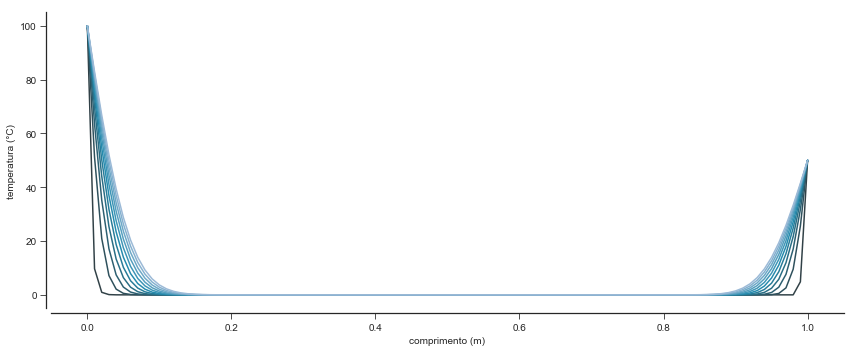

In [4]:
# Inicializando a temperatura na barra
T = np.zeros(nx)
T[0] = T_i
T[-1] = T_f

# Comprimento da barra
x = np.arange(nx) * dx # m

plt.figure(figsize=(12,5))
plot_interval = 10
n_plots = (np.arange(nt) % plot_interval == 0).sum()
sns.set_palette(sns.color_palette('PuBuGn_d', n_plots))

# Loop implementando as diferenças finitas
for n in np.arange(nt): 
    for i in np.arange(1, nx -1):
        T[i] += lbd *(T[i+1] - 2*T[i] + T[i-1])
    if n % plot_interval == 0:
        plt.plot(x, T, label='%.1f s' % (n*dt))

plt.xlabel('comprimento (m)')
plt.ylabel(u'temperatura (°C)')


sns.despine(offset=5)
plt.axis('tight')
plt.tight_layout()

## Implementação menos inocente usando convolução

Essa implementação usa convolução ao invés do laço simples,
desse modo a equação anterior pode ser reescrita como

$$
T_i^{n+1} = T_i^n + \lambda T_i^n * [1,-2,1],
$$

esse método é bem mais eficiente que o laço simples, especialmente para
muitas amostras.

Vou testar com várias implementações de convolução disponíveis. Talvez algumas delas sejam
coincidentes, ou seja, wrappers para a mesma implementação binária.

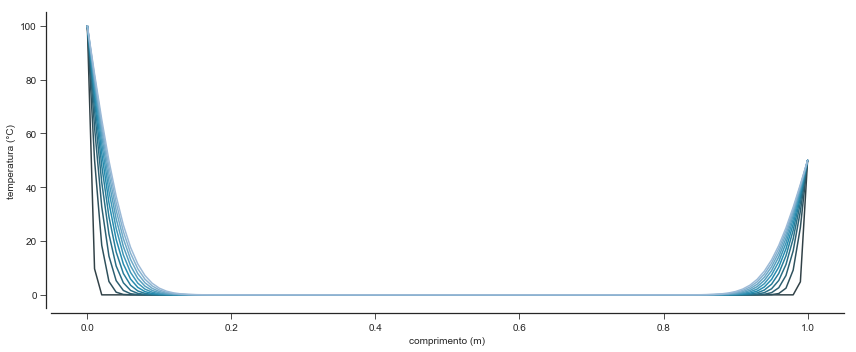

In [5]:
# Inicializando a temperatura na barra
T = np.zeros(nx)
T[0] = T_i
T[-1] = T_f

# Comprimento da barra
x = np.arange(nx) * dx # m

# Kernel para convolução
kernel = np.array([1.,-2.,1.])

plt.figure(figsize=(12,5))
plot_interval = 10
n_plots = (np.arange(nt) % plot_interval == 0).sum()
sns.set_palette(sns.color_palette('PuBuGn_d', n_plots))

# Loop implementando as diferenças finitas
for n in np.arange(nt): 
    T[1:-1] += lbd * np.convolve(T,kernel, mode='valid')
    if n % plot_interval == 0:
        plt.plot(x, T, label='%.1f s' % (n*dt))

plt.xlabel('comprimento (m)')
plt.ylabel(u'temperatura (°C)')


sns.despine(offset=5)
plt.axis('tight')
plt.tight_layout()

In [6]:
from scipy.ndimage.filters import convolve1d

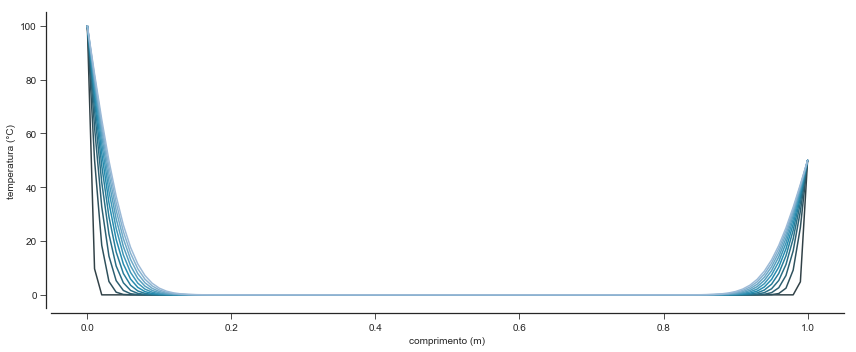

In [7]:
# Inicializando a temperatura na barra
T = np.zeros(nx)
T[0] = T_i
T[-1] = T_f

# Comprimento da barra
x = np.arange(nx) * dx # m

# Kernel para convolução
kernel = np.array([1.,-2.,1.])

plt.figure(figsize=(12,5))
plot_interval = 10
n_plots = (np.arange(nt) % plot_interval == 0).sum()
sns.set_palette(sns.color_palette('PuBuGn_d', n_plots))

# Loop implementando as diferenças finitas
for n in np.arange(nt): 
    T[1:-1] += lbd * convolve1d(T,kernel, mode='wrap')[1:-1]
    if n % plot_interval == 0:
        plt.plot(x, T, label='%.1f s' % (n*dt))

plt.xlabel('comprimento (m)')
plt.ylabel(u'temperatura (°C)')

sns.despine(offset=5)
plt.axis('tight')
plt.tight_layout()

In [8]:
from scipy.signal import convolve

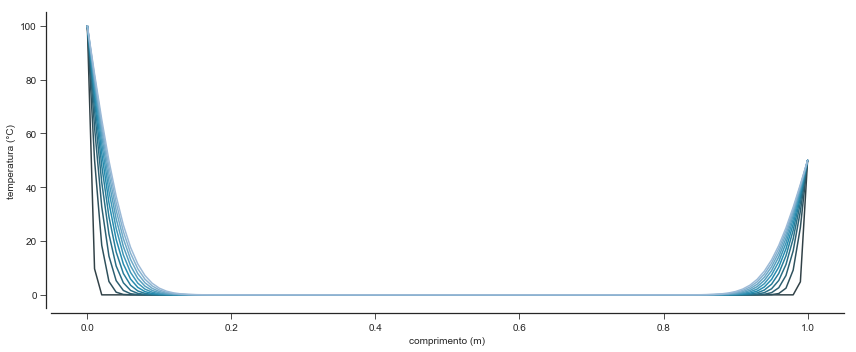

In [9]:
# Inicializando a temperatura na barra
T = np.zeros(nx)
T[0] = T_i
T[-1] = T_f

# Comprimento da barra
x = np.arange(nx) * dx # m

# Kernel para convolução
kernel = np.array([1.,-2.,1.])

plt.figure(figsize=(12,5))
plot_interval = 10
n_plots = (np.arange(nt) % plot_interval == 0).sum()
sns.set_palette(sns.color_palette('PuBuGn_d', n_plots))

# Loop implementando as diferenças finitas
for n in np.arange(nt): 
    T[1:-1] += lbd * convolve(T,kernel, mode='valid')
    if n % plot_interval == 0:
        plt.plot(x, T, label='%.1f s' % (n*dt))

plt.xlabel('comprimento (m)')
plt.ylabel(u'temperatura (°C)')

sns.despine(offset=5)
plt.axis('tight')
plt.tight_layout()

## Implementação função de diferenciação

Dessa vez usei a função de diferenciação para realizar a diferença finita.

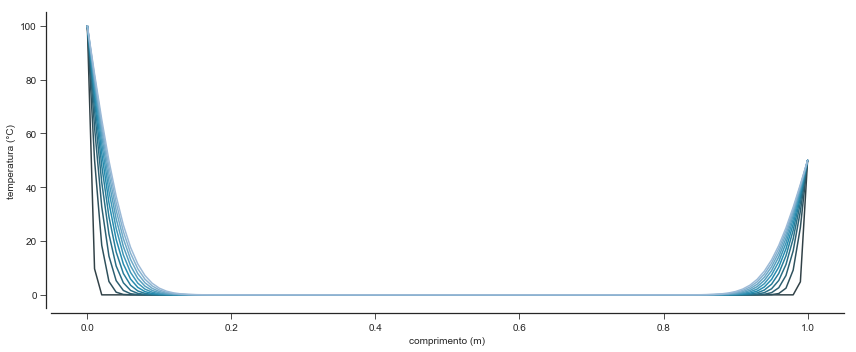

In [10]:
# Inicializando a temperatura na barra
T = np.zeros(nx)
T[0] = T_i
T[-1] = T_f

# Comprimento da barra
x = np.arange(nx) * dx # m

plt.figure(figsize=(12,5))
plot_interval = 10
n_plots = (np.arange(nt) % plot_interval == 0).sum()
sns.set_palette(sns.color_palette('PuBuGn_d', n_plots))

# Loop implementando as diferenças finitas
for n in np.arange(nt): 
    T[1:-1] += lbd * np.diff(T,2)
    if n % plot_interval == 0:
        plt.plot(x, T, label='%.1f s' % (n*dt))

plt.xlabel('comprimento (m)')
plt.ylabel(u'temperatura (°C)')

sns.despine(offset=5)
plt.axis('tight')
plt.tight_layout()

## Comparando a velocidade das implementações

In [11]:
%%timeit

# Inicializando a temperatura na barra
T = np.zeros(nx)
T[0] = T_i
T[-1] = T_f

# Loop implementando as diferenças finitas
for n in np.arange(nt): 
    for i in np.arange(1, nx -1):
        T[i] += lbd *(T[i+1] - 2*T[i] + T[i-1])

100 loops, best of 3: 15.2 ms per loop


In [12]:
%%timeit 

# Inicializando a temperatura na barra
T = np.zeros(nx)
T[0] = T_i
T[-1] = T_f

# Kernel para convolução
kernel = np.array([1.,-2.,1.])

# Loop implementando as diferenças finitas
for n in np.arange(nt): 
    T[1:-1] += lbd * np.convolve(T,kernel, mode='valid')

1000 loops, best of 3: 923 µs per loop


In [13]:
%%timeit

# Inicializando a temperatura na barra
T = np.zeros(nx)
T[0] = T_i
T[-1] = T_f

# Loop implementando as diferenças finitas
for n in np.arange(nt): 
    T[1:-1] += lbd * np.diff(T,2)

1000 loops, best of 3: 1.15 ms per loop


In [14]:
%%timeit 

# Inicializando a temperatura na barra
T = np.zeros(nx)
T[0] = T_i
T[-1] = T_f

# Kernel para convolução
kernel = np.array([1.,-2.,1.])

# Loop implementando as diferenças finitas
for n in np.arange(nt): 
    T[1:-1] += lbd * convolve1d(T,kernel, mode='wrap')[1:-1]

1000 loops, best of 3: 1.89 ms per loop


In [15]:
%%timeit 

# Inicializando a temperatura na barra
T = np.zeros(nx)
T[0] = T_i
T[-1] = T_f

# Kernel para convolução
kernel = np.array([1.,-2.,1.])

# Loop implementando as diferenças finitas
for n in np.arange(nt): 
    T[1:-1] += lbd * convolve(T,kernel, mode='valid')

1000 loops, best of 3: 1.03 ms per loop
